In [29]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

Loading scraped data.

In [30]:
df = pd.read_csv("apartments.csv")

Exploring the first 5 rows

In [31]:
print(df.head())


      City         District                 Street     Area  Rooms  Floor  \
0  Vilnius      Santariškės          Dangeručio g.  66,69m2      3      3   
1   Kaunas  Žemieji Šančiai  A. Juozapavičiaus pr.  41,67m2      2      4   
2  Vilnius      Pašilaičiai           Sviliškių g.  76,52m2      4      3   
3  Vilnius      Pašilaičiai           Sviliškių g.  34,77m2      1      3   
4  Vilnius        Grigiškės            Vilniaus g.  34,34m2      1      7   

   Year Building Type                                Heating Furnishing  \
0  2022         Brick                  Electric, aerothermal    Partial   
1  2023         Other  Central, electric, central thermostat    Partial   
2  2023         Brick                     Central thermostat      Fully   
3  2023         Brick                     Central thermostat      Fully   
4  1990         Brick                                Central        Not   

  EnergyClass   Price  
0         A++  167000  
1         A++  112509  
2         NaN 

Data cleaning

In [32]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6511 entries, 0 to 6510
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   City           6511 non-null   object
 1   District       6511 non-null   object
 2   Street         6511 non-null   object
 3   Area           6511 non-null   object
 4   Rooms          6511 non-null   int64 
 5   Floor          6511 non-null   int64 
 6   Year           6511 non-null   int64 
 7   Building Type  6511 non-null   object
 8   Heating        6511 non-null   object
 9   Furnishing     6511 non-null   object
 10  EnergyClass    1033 non-null   object
 11  Price          6511 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 610.5+ KB
None


Here we can analyze the means, max, min etc. with df.describe. On average, the apartments have 2.36 rooms and are on the 3.19th floor of their building, average year of construction for the apartments is 1988. The average price for an apartment in the dataset is 131,450, but there is a lot of variability in the prices. The cheapest apartment is listed for 346 and the most expensive for 2,030,000.

In [33]:
print(df.describe())

             Rooms        Floor         Year         Price
count  6511.000000  6511.000000  6511.000000  6.511000e+03
mean      2.359392     3.186147  1988.420519  1.314508e+05
std       0.945766     2.299682    29.520501  1.305770e+05
min       1.000000     0.000000  1111.000000  3.460000e+02
25%       2.000000     2.000000  1971.000000  5.900000e+04
50%       2.000000     3.000000  1986.000000  9.900000e+04
75%       3.000000     4.000000  2017.000000  1.602000e+05
max       8.000000    33.000000  2025.000000  2.030000e+06


Checking for missing values. It seems that EnergyClass has 5,4k missing values. Dropping this row completely, to not cause inaccurate model

In [34]:
print(df.isnull().sum())

City                0
District            0
Street              0
Area                0
Rooms               0
Floor               0
Year                0
Building Type       0
Heating             0
Furnishing          0
EnergyClass      5478
Price               0
dtype: int64


In [35]:
df = df.drop('EnergyClass', axis=1)

Checking if there's duplicates, it seems that 256 items are duplicated, people could uploaded their apartament twice(or more) by accident. Dropping them

In [36]:
print(df.duplicated().sum())

256


In [37]:
df = df.drop_duplicates()

Checking datatypes, it seems that Area column is detected as string, this is prob due to m2 at the end, removing it and trasforming to float

In [38]:
print(df.dtypes)

City             object
District         object
Street           object
Area             object
Rooms             int64
Floor             int64
Year              int64
Building Type    object
Heating          object
Furnishing       object
Price             int64
dtype: object


In [39]:
df['Area'] = df['Area'].str.replace(',', '.').str.replace('m2', '').astype(float)


In [40]:
print(df.dtypes)

City              object
District          object
Street            object
Area             float64
Rooms              int64
Floor              int64
Year               int64
Building Type     object
Heating           object
Furnishing        object
Price              int64
dtype: object


Checking for uniques in harder-to-scrape columns

In [41]:
df['Area'].unique

<bound method Series.unique of 0       66.69
1       41.67
2       76.52
3       34.77
4       34.34
        ...  
6506    60.00
6507    61.00
6508    34.00
6509    69.00
6510    33.22
Name: Area, Length: 6255, dtype: float64>

In [42]:
df['Year'].unique

<bound method Series.unique of 0       2022
1       2023
2       2023
3       2023
4       1990
        ... 
6506    1993
6507    1970
6508    1978
6509    2022
6510    1982
Name: Year, Length: 6255, dtype: int64>

In [43]:
df['Building Type'].unique

<bound method Series.unique of 0             Brick
1             Other
2             Brick
3             Brick
4             Brick
           ...     
6506          Brick
6507    Block house
6508          Brick
6509          Brick
6510    Block house
Name: Building Type, Length: 6255, dtype: object>

In [44]:
df['Heating'].unique

<bound method Series.unique of 0                       Electric, aerothermal
1       Central, electric, central thermostat
2                          Central thermostat
3                          Central thermostat
4                                     Central
                        ...                  
6506                                  Central
6507                                 Electric
6508                                  Central
6509                                      Gas
6510                                  Central
Name: Heating, Length: 6255, dtype: object>

In [45]:
df['Furnishing'].unique

<bound method Series.unique of 0       Partial
1       Partial
2         Fully
3         Fully
4           Not
         ...   
6506      Fully
6507        Not
6508      Fully
6509      Fully
6510      Fully
Name: Furnishing, Length: 6255, dtype: object>

After cleaning data, we have 6255 results left. (Out of 6511)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6255 entries, 0 to 6510
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           6255 non-null   object 
 1   District       6255 non-null   object 
 2   Street         6255 non-null   object 
 3   Area           6255 non-null   float64
 4   Rooms          6255 non-null   int64  
 5   Floor          6255 non-null   int64  
 6   Year           6255 non-null   int64  
 7   Building Type  6255 non-null   object 
 8   Heating        6255 non-null   object 
 9   Furnishing     6255 non-null   object 
 10  Price          6255 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 586.4+ KB


Exporting the new cleaned file in a fresh CSV file

In [47]:
df.to_csv("apartments_clean.csv", index=False)

---------------------------------------------------------------------------------------------------------------------------------------------------------
Loading new clean data

In [48]:
data = pd.read_csv("apartments_clean.csv")

Let's look at Top 5 apartaments by cities.

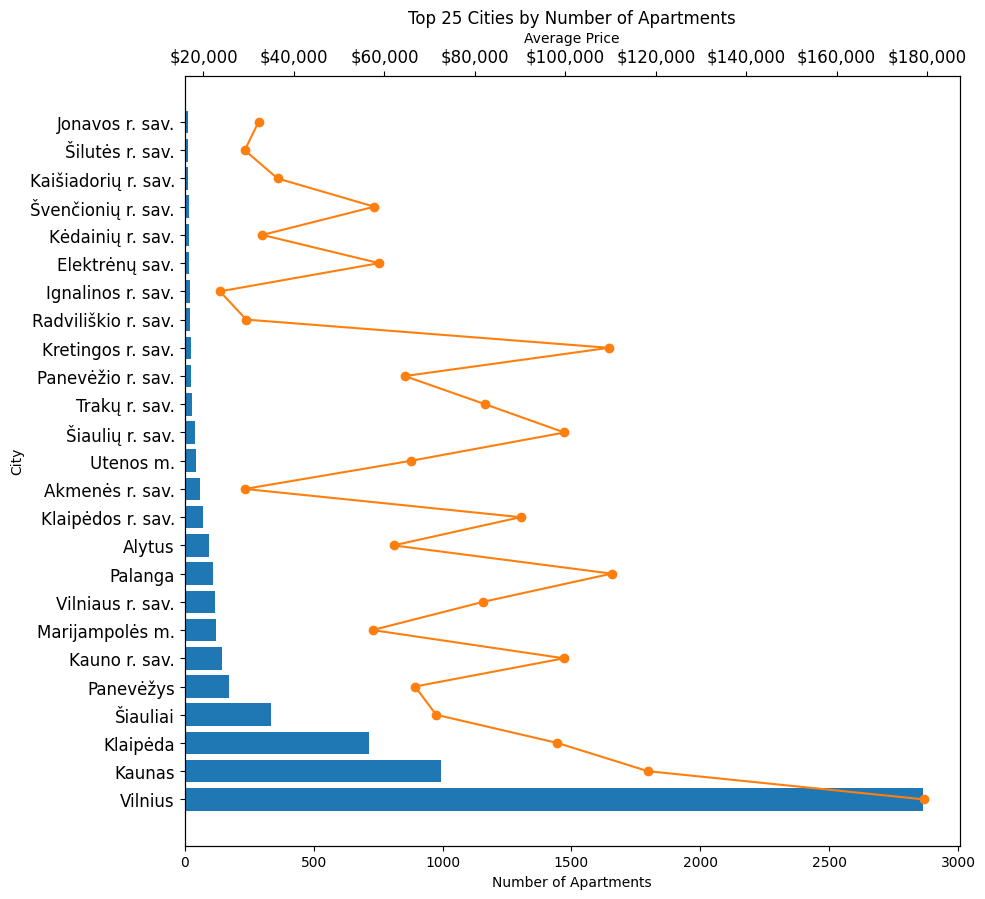

In [49]:
city_stats = data.groupby('City').agg({'Price': 'mean', 'Rooms': 'count'})
top_cities = city_stats.nlargest(25, 'Rooms')

fig, ax1 = plt.subplots(figsize=(10,10))
ax1.barh(top_cities.index, top_cities['Rooms'], color='C0')
ax1.set_xlabel('Number of Apartments')
ax1.set_ylabel('City')
ax1.tick_params(axis='y', labelsize=12)

ax2 = ax1.twiny()
ax2.plot(top_cities['Price'], top_cities.index, color='C1', marker='o')
ax2.set_xlabel('Average Price')
ax2.tick_params(axis='x', labelsize=12)
ax2.xaxis.set_major_formatter('${x:,.0f}')

plt.title('Top 25 Cities by Number of Apartments')

plt.show()

Scatterplot of how much price changes based on area m2

Text(0.5, 1.0, 'Price vs. Area m2')

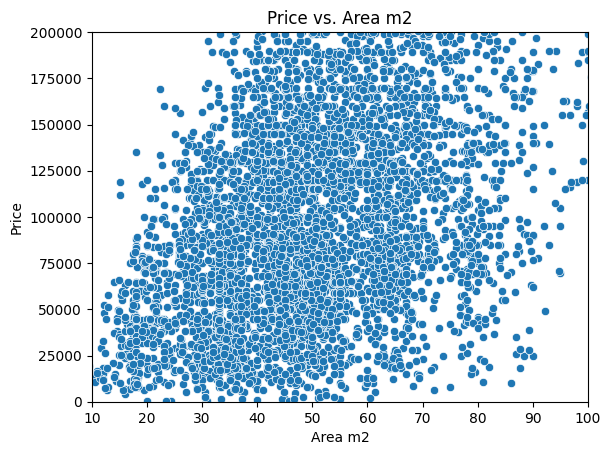

In [50]:
sns.scatterplot(x='Area', y='Price', data=data)
plt.xlim(10, 100)
plt.ylim(0, 200000)

plt.xlabel('Area m2')
plt.ylabel('Price')
plt.title('Price vs. Area m2')


In the analysis of the Year Distribution, it can be observed that the majority of the apartments in the dataset were constructed in the year 2020, however, a noteworthy observation is that there is a significant number of apartments built around 1990.

Text(0.5, 1.0, 'Year Distribution')

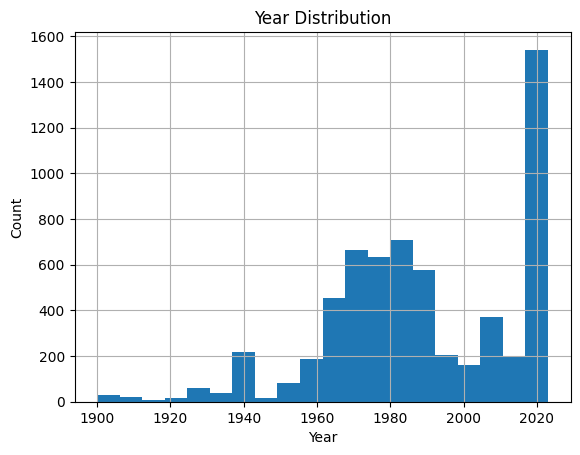

In [51]:
data['Year'].hist(bins=20, range=(1900, 2023))
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Distribution')

Box Plot of Prices vs Rooms.

Text(0.5, 1.0, 'Price by Number of Rooms')

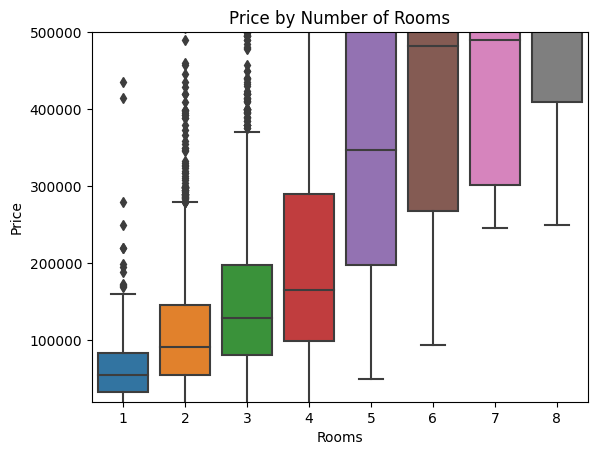

In [52]:
sns.boxplot(x='Rooms', y='Price', data=data)
plt.ylim(20000, 500000)
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Price by Number of Rooms')

Correlation Matrix

C:\Users\user\AppData\Local\Temp\ipykernel_14696\3391414771.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


Text(0.5, 1.0, 'Correlation Matrix')

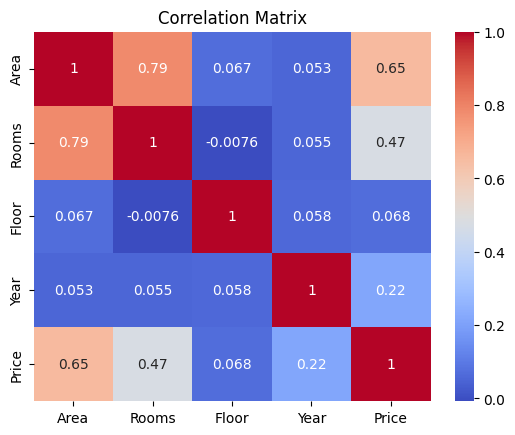

In [53]:
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')

Apartments prices over years

C:\Users\user\AppData\Local\Temp\ipykernel_14696\3667756984.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  price_by_year = data.groupby('Year').mean()['Price']


Text(0.5, 1.0, 'Average Price of Apartments Over Time')

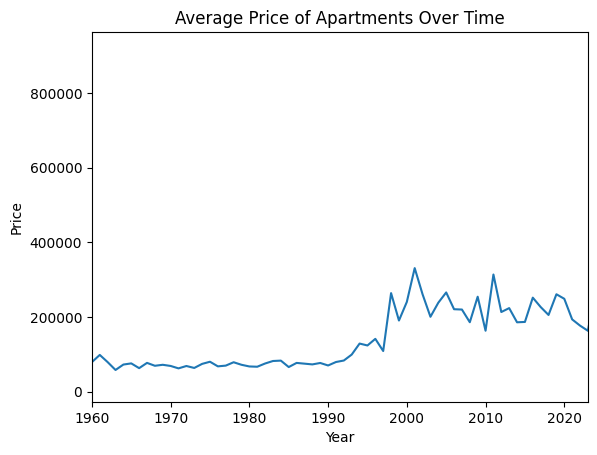

In [54]:
price_by_year = data.groupby('Year').mean()['Price']
plt.xlim(1960, 2023)
plt.plot(price_by_year.index, price_by_year.values)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Average Price of Apartments Over Time')

Caluclating price per square meter

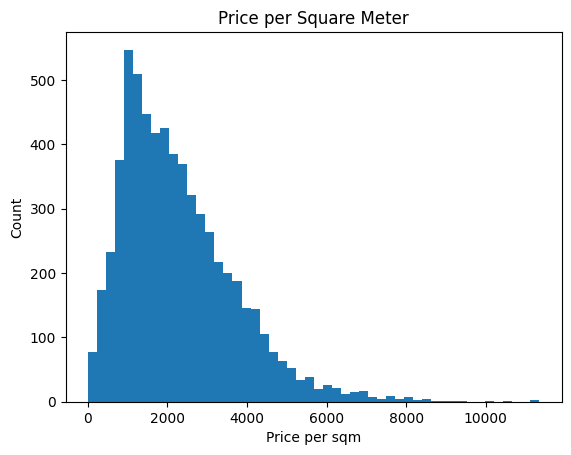

In [55]:
# Create a new column for price per square meter
data['Price per sqm'] = data['Price'] / data['Area']

plt.hist(data['Price per sqm'], bins=50)
plt.xlabel('Price per sqm')
plt.ylabel('Count')
plt.title('Price per Square Meter')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------
Model for predicting apartment price

In [78]:
model = pd.read_csv("apartments_clean.csv")

Creating dummies for colums, splitting data into training and testing.

In [79]:
model = model.drop(['Rooms'], axis=1)
model = model.drop(['Street'], axis=1)
model = model.drop(['District'], axis=1)
model = model.drop(['City'], axis=1)
model = model.drop(['Heating'], axis=1)





In [76]:
print(model.columns)

Index(['City', 'Area', 'Floor', 'Year', 'Building Type', 'Heating',
       'Furnishing', 'Price'],
      dtype='object')


Training model

In [80]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train the Ridge regression model with alpha=0.1 (you can adjust this parameter to control the strength of regularization)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

# make predictions on the test set
y_pred = ridge.predict(X_test)

# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

Mean squared error: 5886786856.174734


We can see that the mean squared error is way to big, so some features might be messing it up.

Regularization